In [33]:
import toml
import random
import joblib
import numpy as np
import pandas as pd
import colorcet as cc
import seaborn as sns
import matplotlib.pyplot as plt

from toolz import get
from scipy import signal
from os.path import join
from tqdm.auto import tqdm
from rl_analysis import ANALYSIS_CONFIG
from rl_analysis.behavior.moseq import syll_onset
from rl_analysis.bootstraps import bootstrap_ci
from rl_analysis.io.df import dlight_exclude_toml, NONSYLL_COLS
from rl_analysis.photometry.windowing import window_trials_as_df, window_trials_as_mtx
from rl_analysis.plotting import setup_plotting_env, clean_ticks, save_factory, add_legend, bootstrap_lineplot, fg

In [34]:
with open(ANALYSIS_CONFIG, 'r') as f:
    config = toml.load(f)

In [35]:
setup_plotting_env()

In [5]:
color_map = {
    "Run": cc.glasbey[3],
    "Groom": cc.glasbey[6],
    "Rear 1": cc.glasbey[3],
    "Rear 2": cc.glasbey[6],
}

color_map = {
    "Pause and investigate": cc.glasbey[11],
    "Turn left": cc.glasbey[6],
    "Rear 1": cc.glasbey[11],
    "Rear 2": cc.glasbey[6],
}
syllable_map = {
    "Run": 74,
    "Groom": 42,
    "Rear 1": 59,
    "Rear 2": 66,
}

syllable_map = {
    "Pause and investigate": 5,
    "Turn left": 72,
    "Rear 1": 59,
    "Rear 2": 66,
}
dlight_key = config['dlight_basic_analysis']['dlight_key']

In [8]:
saver = save_factory(join(config['figures']['dir_wg'], 'fig-01'), tight_layout=False)

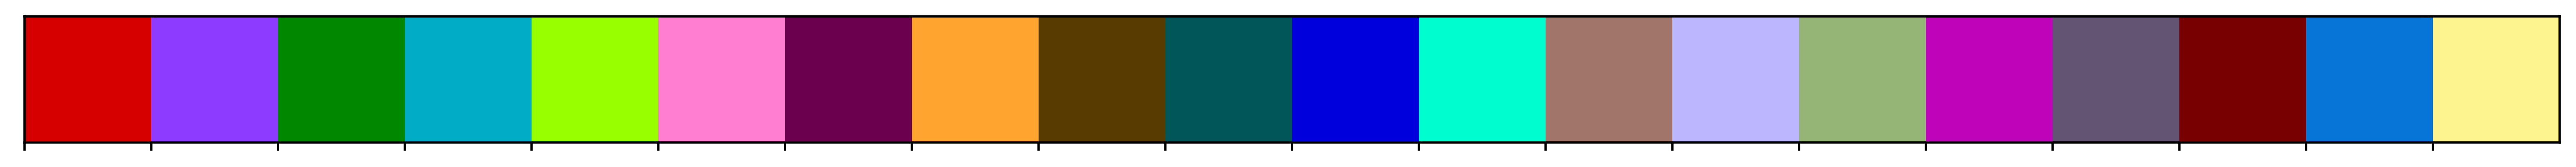

In [11]:
sns.palplot(cc.glasbey[:20], size=1)

## Load data

In [14]:
NONSYLL_COLS.pop(NONSYLL_COLS.index("velocity_2d_mm"))

'velocity_2d_mm'

In [15]:
use_dct = dlight_exclude_toml(
    "/home/wg41/reinforcement_data/_proc_photometry_dlight/dlight_photometry_processed_full.toml",
    **config["dlight_common"]
)

df = pd.read_parquet(
    config['intermediate_results']['dlight_public'],
    filters=[("uuid", "in", list(use_dct)), ("area", "=", "dls")],
)

df = df[~df['session_number'].isin([3, 4])]
df = df.drop(columns=NONSYLL_COLS)
df = df.sort_index()

df['offline onset'] = False
df.loc[df.index[syll_onset(df['predicted_syllable (offline)'])], 'offline onset'] = True
df['velocity_2d_mm'] = df['velocity_2d_mm'].astype(float)

In [18]:
def dlight_filter(ser):
    soscoeffs = signal.bessel(1, 1 / (30 / 2.), btype="high", output="sos")
    sig = ser.dropna()
    new_ser = pd.Series(index=ser.index, dtype=float)
    new_ser.loc[sig.index] = signal.sosfiltfilt(soscoeffs, sig)
    return new_ser

In [19]:
df["dlight filtered"] = df.groupby("uuid", sort=False, observed=True)[
    "signal_reref_dff_z"
].transform(dlight_filter)

In [20]:
time_window = (-1.5, 1.5)

In [44]:
def shuffle(val, inds):
    time, trials = window_trials_as_mtx(
        pd.DataFrame(val, columns=[dlight_key]),
        inds + np.array(list(map(lambda v: random.randint(-60, 60), range(len(inds))))),
        dlight_key,
        truncation_window=time_window,
    )
    return np.nanmean(trials, axis=0)


# def parallel_shuffle(df, syllable, n_shuffles=1_000, n_jobs=3):
#     # will be n_shuffles in length
#     shuff_avgs = Parallel(n_jobs=n_jobs)(
#         delayed(shuffle)(df[dlight_key].copy(), syllable) for _ in tqdm(range(n_shuffles))
#     )
#     return np.array(shuff_avgs)


def serial_shuffle(df, syllable, n_shuffles=1_000):
    return np.array([shuffle(df[dlight_key], syllable) for _ in tqdm(range(n_shuffles))])


def zscore_re_shuffle(trial_df, shuffle):
    mu = np.nanmean(shuffle, axis=0)
    sig = np.nanstd(shuffle, axis=0)

    trial_df["z_dlight"] = trial_df.groupby("trials")["dlight"].transform(lambda d: (d - mu) / sig)
    return trial_df

In [45]:
n_shuffles = 1_000
syll_key = "predicted_syllable (offline)"
dlight_key = "dlight filtered"

datas = {}

for syll_name, syll in tqdm(syllable_map.items()):
    inds = np.where(df["offline onset"] & (df[syll_key] == syll))[0]

    shuff = serial_shuffle(df, inds, n_shuffles=n_shuffles)

    # dLight
    _, trial_df = window_trials_as_df(
        df,
        inds,
        dlight_key,
        truncation_window=time_window,
    )
    trial_df = zscore_re_shuffle(trial_df, shuff)
    trial_df["type"] = syll_name

    # velocity
    _, vel_trial_df = window_trials_as_df(
        df,
        np.where(df["offline onset"] & (df[syll_key] == syll))[0],
        "velocity_2d_mm",
        syll_key,
        truncation_window=time_window,
    )

    bootstraps = {}
    # bootstrap
    for key in ("dlight", "z_dlight"):
        b1 = trial_df.pivot_table(index="trials", columns="time", values=key)
        mu = b1.mean()
        b1 = bootstrap_ci(b1.to_numpy(), n_shuffles)
        b1 = pd.DataFrame(b1.T, index=mu.index)
        b1 = b1.reset_index().melt(var_name="boot", id_vars="time", value_name="dlight")
        b1["type"] = syll_name
        prefix = "z_" if "z_" in key else ""
        bootstraps[f"{prefix}bootstrap"] = b1
        bootstraps[f"{prefix}mean"] = mu

    v = vel_trial_df.pivot_table(index="trials", columns="time", values="dlight")
    v = bootstrap_ci(v.to_numpy(), n_shuffles)
    v = pd.DataFrame(v.T, index=mu.index)
    v = v.reset_index().melt(var_name="boot", id_vars="time", value_name="velocity")
    v["type"] = syll_name

    # save output
    datas[syll] = {
        "syllable name": syll_name,
        "syllable id": syll,
        "shuffles": shuff,
        "aligned dlight": trial_df,
        "aligned velocity": vel_trial_df,
        "n_shuffs": n_shuffles,
        "velocity_bootstrap": v,
        **bootstraps,
    }

joblib.dump(
    datas,
    "/home/wg41/reinforcement_data/processed-dfs/similar-dissimilar-filtered-waveforms-panel.p",
)

In [29]:
# datas = joblib.load(
#     "/home/wg41/reinforcement_data/processed-dfs/similar-dissimilar-filtered-waveforms-panel.p"
# )

In [30]:
list((x['syllable name'], x['syllable id']) for x in datas.values())

[('Pause and investigate', 5),
 ('Turn left', 72),
 ('Rear 1', 59),
 ('Rear 2', 66)]

## Panel: different dLight similar kinematics - dLight

In [47]:
different_da_sylls = [66, 59]

shuff_line = []
for _data in get(different_da_sylls, datas):
    shuffs = _data['shuffles']
    shuff_line.append(
        (shuffs - np.nanmean(shuffs, 0, keepdims=True)) / np.nanstd(shuffs, 0, keepdims=True)
    )
shuff_line = pd.DataFrame(np.concatenate(shuff_line, axis=0).T, index=_data['mean'].index)
shuff_line = shuff_line.reset_index().melt(var_name='boot', id_vars='time', value_name='dlight')

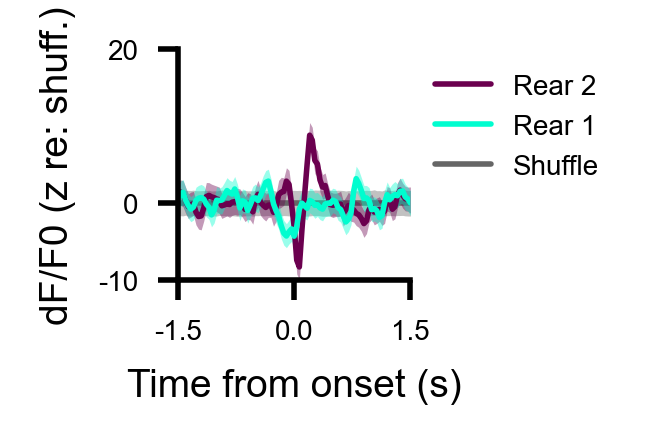

In [48]:
fig = fg(0.75, 0.75)
fig.dpi = 200
for _data in get(different_da_sylls, datas):
    ax = bootstrap_lineplot(
        _data["z_bootstrap"],
        "time",
        "dlight",
        ci=95,
        color=color_map[_data["syllable name"]],
        label=_data["syllable name"],
        alpha=0.4,
    )

bootstrap_lineplot(
    shuff_line,
    "time",
    "dlight",
    ci=95,
    color=(0.4,) * 3,
    label="Shuffle",
    alpha=0.4,
    zorder=-2,
)

add_legend(ax)
plt.ylabel("dF/F0 (z re: shuff.)")
plt.xlabel("Time from onset (s)")
plt.xlim(-1.5, 1.5)
plt.ylim(-10, 20)
clean_ticks(ax, "y", dtype=int, precision=0, zero_symmetry=False)
clean_ticks(ax, "x", dtype=float)
sns.despine()
saver(fig, "different-filtered-dlight-similar-kinematics-filtered-dlight-z-shuffle");

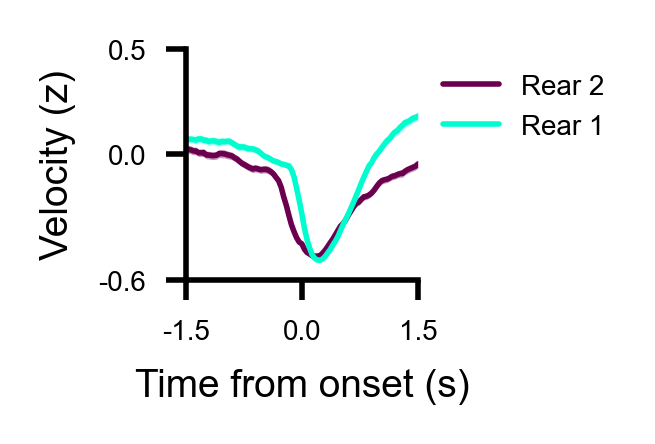

In [49]:
fig = fg(0.75, 0.75)
fig.dpi = 200
for _data in get(different_da_sylls, datas):
    ax = bootstrap_lineplot(
        _data["velocity_bootstrap"],
        "time",
        "velocity",
        ci=95,
        color=color_map[_data["syllable name"]],
        label=_data["syllable name"],
        alpha=0.4,
    )

add_legend(ax)
plt.ylabel("Velocity (z)")
plt.xlabel("Time from onset (s)")
plt.xlim(-1.5, 1.5)
plt.ylim(-0.6, 0.5)
clean_ticks(ax, "y", zero_symmetry=False)
clean_ticks(ax, "x", dtype=float)
sns.despine()
saver(fig, "different-filtered-dlight-similar-kinematics-velocity");

## Panel - similar DA different kinematics - dLight

In [50]:
similar_da_sylls = [72, 5]

shuff_line = []
for _data in get(similar_da_sylls, datas):
    shuffs = _data['shuffles']
    shuff_line.append(
        (shuffs - np.nanmean(shuffs, 0, keepdims=True)) / np.nanstd(shuffs, 0, keepdims=True)
    )
shuff_line = pd.DataFrame(np.concatenate(shuff_line, axis=0).T, index=_data['mean'].index)
shuff_line = shuff_line.reset_index().melt(var_name='boot', id_vars='time', value_name='dlight')

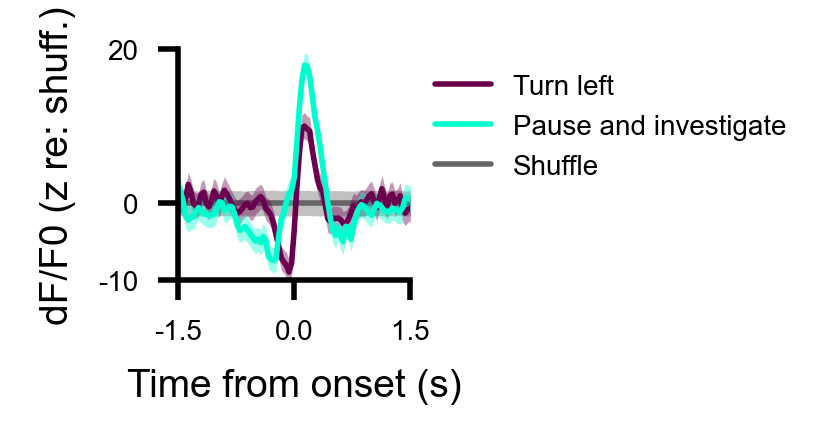

In [51]:
fig = fg(0.75, 0.75)
fig.dpi = 200
for _data in get(similar_da_sylls, datas):
    ax = bootstrap_lineplot(
        _data["z_bootstrap"],
        "time",
        "dlight",
        ci=95,
        color=color_map[_data["syllable name"]],
        label=_data["syllable name"],
        alpha=0.4,
    )

bootstrap_lineplot(
    shuff_line, "time", "dlight", ci=95, color=(0.4,) * 3, label="Shuffle", alpha=0.4, zorder=-2
)

add_legend(ax)
plt.ylabel("dF/F0 (z re: shuff.)")
plt.xlabel("Time from onset (s)")
plt.xlim(-1.5, 1.5)
plt.ylim(-10, 20)
clean_ticks(ax, "y", dtype=int, precision=0, zero_symmetry=False)
clean_ticks(ax, "x", dtype=float)
sns.despine()
saver(fig, "similar-filtered-dlight-different-kinematics-filtered-dlight-z-shuffle");

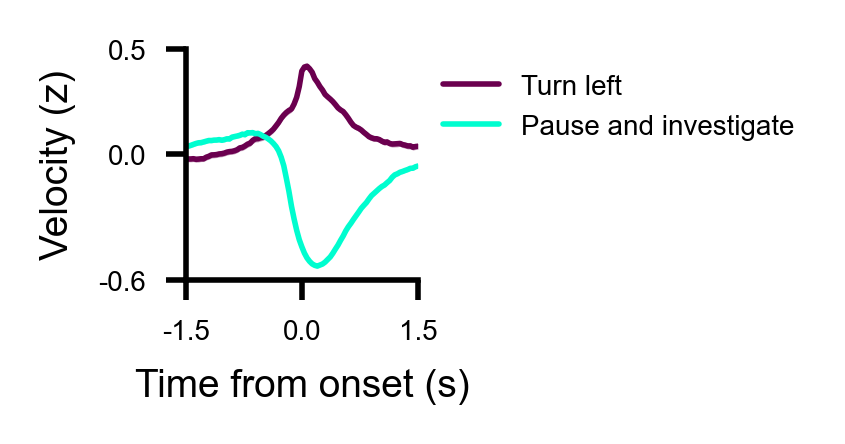

In [52]:
fig = fg(0.75, 0.75)
fig.dpi = 200
for _data in get(similar_da_sylls, datas):
    ax = bootstrap_lineplot(
        _data["velocity_bootstrap"],
        "time",
        "velocity",
        ci=95,
        color=color_map[_data["syllable name"]],
        label=_data["syllable name"],
        alpha=0.4,
    )

add_legend(ax)
plt.ylabel("Velocity (z)")
plt.xlabel("Time from onset (s)")
plt.xlim(-1.5, 1.5)
plt.ylim(-0.6, 0.5)
clean_ticks(ax, "y", zero_symmetry=False)
clean_ticks(ax, "x", dtype=float)
sns.despine()
saver(fig, "similar-filtered-dlight-different-kinematics-velocity");